In [10]:
import os
import torch
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Directories
rgb_dir = r"/home/samy/shivam/dsr_project/dataset/Co-registered/Simulated dataset/images/RGB"
ir_dir = r"/home/samy/shivam/dsr_project/dataset/Co-registered/Simulated dataset/images/norm_ir_8bit"
save_dir = r"/home/samy/shivam/dsr_project/dataset/Co-registered/Simulated dataset/images/fused_4ch"
os.makedirs(save_dir, exist_ok=True)

# Transformation: Resize + ToTensor
transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor()
])

# List and match files
rgb_files = sorted([f for f in os.listdir(rgb_dir) if f.endswith(('.jpg', '.png'))])
ir_files = sorted([f for f in os.listdir(ir_dir) if f.endswith(('.jpg', '.png'))])
ir_file_set = set(ir_files)

for rgb_file in rgb_files:
    if rgb_file in ir_file_set:
        rgb_path = os.path.join(rgb_dir, rgb_file)
        ir_path = os.path.join(ir_dir, rgb_file)

        rgb_img = Image.open(rgb_path).convert("RGB")
        ir_img = Image.open(ir_path).convert("L")

        rgb_tensor = transform(rgb_img)  # [3, H, W]
        ir_tensor = transform(ir_img)    # [1, H, W]

        assert rgb_tensor.shape[1:] == ir_tensor.shape[1:], f"Size mismatch at {rgb_file}"

        fused_tensor = torch.cat((rgb_tensor, ir_tensor), dim=0)

        # Save with the same base filename but .pt extension
        base_name = os.path.splitext(rgb_file)[0]
        fused_save_path = os.path.join(save_dir, f"{base_name}.pt")
        torch.save(fused_tensor, fused_save_path)
    else:
        print(f"Warning: No matching IR image for {rgb_file}")

print("Fusion and saving done ✅")


Fusion and saving done ✅


In [11]:
import os

fused_dir = "/home/samy/shivam/dsr_project/dataset/Co-registered/Simulated dataset/images/fused_4ch"
mask_dir  = "/home/samy/shivam/dsr_project/dataset/Co-registered/Simulated dataset/saliency_masks"

fused_files = sorted([f for f in os.listdir(fused_dir) if f.endswith(".pt")])
mask_files  = sorted([f for f in os.listdir(mask_dir)  if f.endswith((".png", ".jpg"))])

print(f"Fused (.pt) count: {len(fused_files)}")
print(f"Masks   (.png/.jpg) count: {len(mask_files)}")

# compute basenames
fused_bases = {os.path.splitext(f)[0] for f in fused_files}
mask_bases  = {os.path.splitext(f)[0] for f in mask_files}

only_in_fused = fused_bases - mask_bases
only_in_masks = mask_bases - fused_bases

print("Present in fused but no mask for:", only_in_fused)
print("Present in masks but no fused .pt for:", only_in_masks)


Fused (.pt) count: 2751
Masks   (.png/.jpg) count: 2751
Present in fused but no mask for: set()
Present in masks but no fused .pt for: set()


Fused image shape: torch.Size([4, 320, 320])


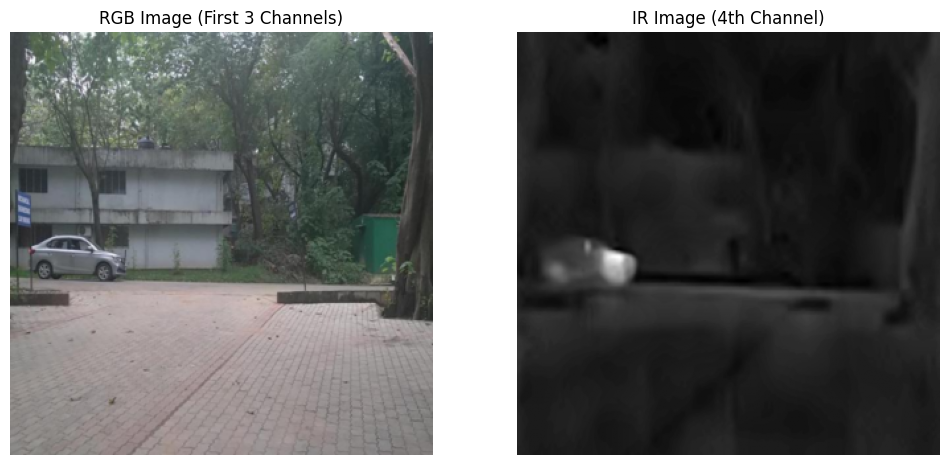

In [12]:
# Load a sample fused tensor
sample_path = r"/home/samy/shivam/dsr_project/dataset/Co-registered/Simulated dataset/images/fused_4ch/flir_4.pt"  # Change the index as needed
fused = torch.load(sample_path)  # Shape: [4, 256, 256]

print(f"Fused image shape: {fused.shape}")  # Should be [4, 256, 256]

# Display RGB part (first 3 channels)
rgb_image = fused[:3, :, :].permute(1, 2, 0)  # [H, W, 3] for plt.imshow

# Display IR part (4th channel)
ir_image = fused[3, :, :]  # [H, W] for grayscale

# Plot
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.imshow(rgb_image)
plt.title('RGB Image (First 3 Channels)')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(ir_image, cmap='gray')
plt.title('IR Image (4th Channel)')
plt.axis('off')

plt.show()


In [13]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
from torchsummary import summary
from sklearn.metrics import precision_score, recall_score, f1_score

In [14]:
class SaliencyDataset4Channel_PT(Dataset):
    def __init__(self, image_paths, mask_paths, transform_image=None, transform_mask=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform_image = transform_image
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load 4-channel tensor image from .pt file
        image = torch.load(self.image_paths[idx])  # Loaded as tensor directly
        if image.dim() == 3 and image.shape[0] != 4:
            raise ValueError(f"Expected 4-channel image, but got shape {image.shape}")

        # Load mask (still normal image file)
        mask = Image.open(self.mask_paths[idx]).convert("L")

        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask

In [15]:
# Image and mask directories
image_dirs = [    
    r"/home/samy/shivam/dsr_project/dataset/Co-registered/Simulated dataset/images/fused_4ch"
]

mask_dirs = [
    r"/home/samy/shivam/dsr_project/dataset/Co-registered/Simulated dataset/saliency_masks"
]

# Collect paths
image_files = []
mask_files = []

for img_dir, msk_dir in zip(image_dirs, mask_dirs):
    imgs = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith(".pt")])
    msks = sorted([os.path.join(msk_dir, f) for f in os.listdir(msk_dir) if f.endswith(".png") or f.endswith(".jpg")])

    assert len(imgs) == len(msks), f"Mismatch between images and masks in {img_dir}"

    image_files.extend(imgs)
    mask_files.extend(msks)

# Train-test split
train_imgs, test_imgs, train_masks, test_masks = train_test_split(image_files, mask_files, test_size=0.2, random_state=42)

# Transforms
transform_image = transforms.Compose([
    transforms.Resize((320, 320)),
    # images are already tensors
])

transform_mask = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor()
])

In [16]:
# Datasets and loaders
train_dataset = SaliencyDataset4Channel_PT(train_imgs, train_masks, transform_image=transform_image, transform_mask=transform_mask)
test_dataset = SaliencyDataset4Channel_PT(test_imgs, test_masks, transform_image=transform_image, transform_mask=transform_mask)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

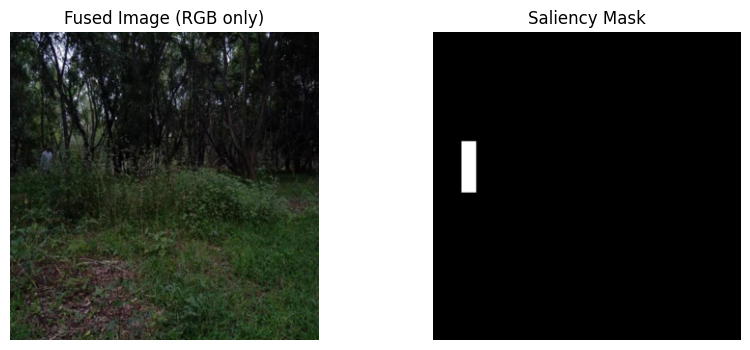

In [18]:
# ---------------------- Visual Check ----------------------
def show_fused_image_with_mask(image_tensor, mask_tensor):
    rgb_tensor = image_tensor[:3]  # Take RGB channels for visualization
    rgb_np = rgb_tensor.permute(1, 2, 0).cpu().numpy()
    mask_np = mask_tensor.squeeze().cpu().numpy()

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(rgb_np)
    plt.title("Fused Image (RGB only)")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask_np, cmap="gray")
    plt.title("Saliency Mask")
    plt.axis("off")
    plt.show()

# Display a sample
sample_img, sample_mask = next(iter(train_loader))
show_fused_image_with_mask(sample_img[11], sample_mask[11])


In [19]:
class Saliency_Fused(nn.Module):
    def __init__(self):
        super(Saliency_Fused, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(4, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Saliency_Fused().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")

Epoch [1/100], Loss: 0.1730
Epoch [2/100], Loss: 0.1283
Epoch [3/100], Loss: 0.1179
Epoch [4/100], Loss: 0.1098
Epoch [5/100], Loss: 0.1001
Epoch [6/100], Loss: 0.0925
Epoch [7/100], Loss: 0.0898
Epoch [8/100], Loss: 0.0840
Epoch [9/100], Loss: 0.0784
Epoch [10/100], Loss: 0.0775
Epoch [11/100], Loss: 0.0713
Epoch [12/100], Loss: 0.0689
Epoch [13/100], Loss: 0.0625
Epoch [14/100], Loss: 0.0639
Epoch [15/100], Loss: 0.0574
Epoch [16/100], Loss: 0.0566
Epoch [17/100], Loss: 0.0554
Epoch [18/100], Loss: 0.0512
Epoch [19/100], Loss: 0.0511
Epoch [20/100], Loss: 0.0483
Epoch [21/100], Loss: 0.0464
Epoch [22/100], Loss: 0.0465
Epoch [23/100], Loss: 0.0490
Epoch [24/100], Loss: 0.0440
Epoch [25/100], Loss: 0.0421
Epoch [26/100], Loss: 0.0415
Epoch [27/100], Loss: 0.0408
Epoch [28/100], Loss: 0.0380
Epoch [29/100], Loss: 0.0391
Epoch [30/100], Loss: 0.0393
Epoch [31/100], Loss: 0.0371
Epoch [32/100], Loss: 0.0338
Epoch [33/100], Loss: 0.0363
Epoch [34/100], Loss: 0.0381
Epoch [35/100], Loss: 0

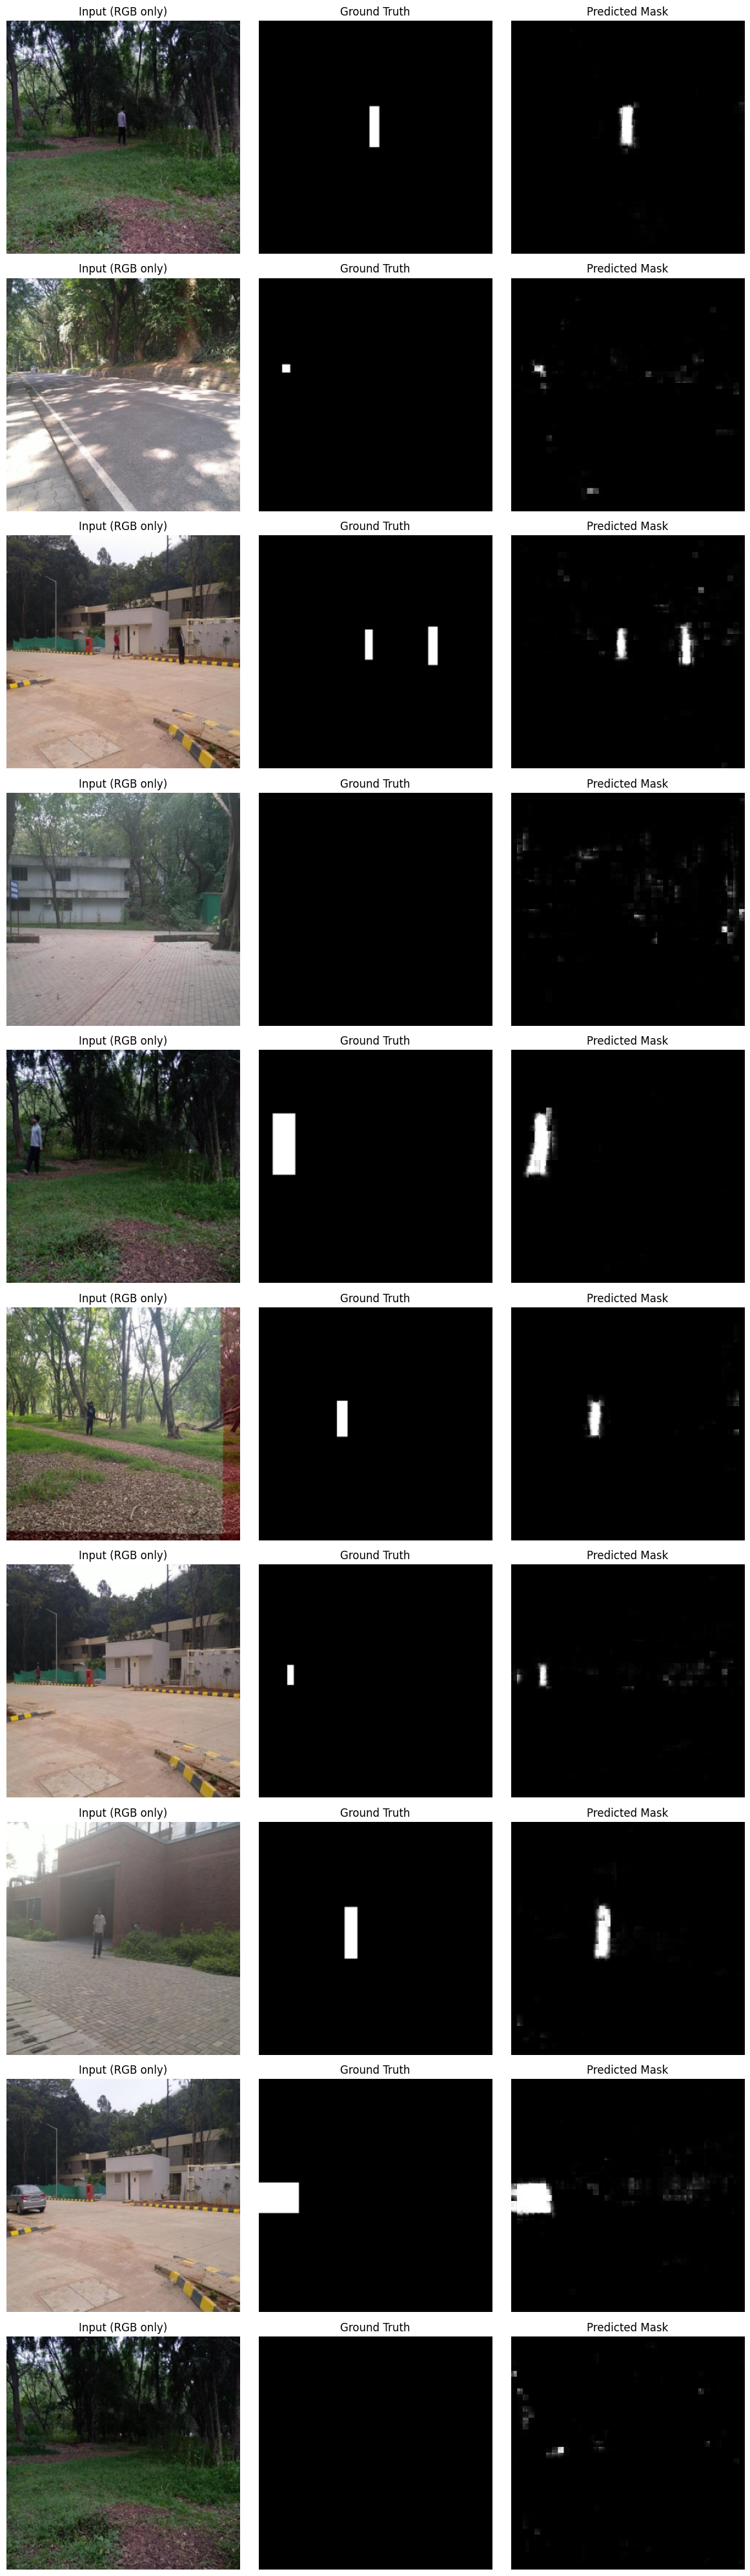

In [22]:
model.eval()
with torch.no_grad():
    random_indices = random.sample(range(len(test_dataset)), 10)
    fig, axes = plt.subplots(10, 3, figsize=(12, 40))

    for idx, random_idx in enumerate(random_indices):
        image, mask = test_dataset[random_idx]  # image: (4, H, W)
        image = image.unsqueeze(0).to(device)
        mask = mask.unsqueeze(0).to(device)

        output = model(image)

        rgb_np = image[0][:3].permute(1, 2, 0).cpu().numpy()
        mask_np = mask[0][0].cpu().numpy()
        output_np = output[0][0].cpu().numpy()

        axes[idx, 0].imshow(rgb_np)
        axes[idx, 0].set_title("Input (RGB only)")
        axes[idx, 0].axis("off")

        axes[idx, 1].imshow(mask_np, cmap='gray')
        axes[idx, 1].set_title("Ground Truth")
        axes[idx, 1].axis("off")

        axes[idx, 2].imshow(output_np, cmap='gray')
        axes[idx, 2].set_title("Predicted Mask")
        axes[idx, 2].axis("off")

    plt.tight_layout()
    plt.show()

In [23]:
torch.save(model.state_dict(), "/home/samy/shivam/dsr_project/Project_files/models/saliency/saliency_model_ef.pth")
print("Model saved as saliency_model_fused.pth")

Model saved as saliency_model_fused.pth


In [24]:
torch.save(model.state_dict(), "/home/samy/shivam/dsr_project/Project_files/models/saliency/saliency_model_early_fusion.pth")
print("Model saved as saliency_model_early_fusion.pth")

Model saved as saliency_model_early_fusion.pth


In [34]:
# Instantiate model and load weights
model = Saliency_Fused().to(device)
model.load_state_dict(torch.load("/home/samy/shivam/dsr_project/Project_files/models/saliency/saliency_model_early_fusion.pth"))
model.eval()

Saliency_Fused(
  (encoder): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(64, 1, kernel_size=(2, 2), stride=(2, 2))
    (5): Sigmoid()
  )
)

In [35]:
# ---------------------- Model Summary ---------------------
summary(model, input_size=(4, 320, 320))   

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 320, 320]           2,368
              ReLU-2         [-1, 64, 320, 320]               0
         MaxPool2d-3         [-1, 64, 160, 160]               0
            Conv2d-4        [-1, 128, 160, 160]          73,856
              ReLU-5        [-1, 128, 160, 160]               0
         MaxPool2d-6          [-1, 128, 80, 80]               0
            Conv2d-7          [-1, 256, 80, 80]         295,168
              ReLU-8          [-1, 256, 80, 80]               0
         MaxPool2d-9          [-1, 256, 40, 40]               0
  ConvTranspose2d-10          [-1, 128, 80, 80]         131,200
             ReLU-11          [-1, 128, 80, 80]               0
  ConvTranspose2d-12         [-1, 64, 160, 160]          32,832
             ReLU-13         [-1, 64, 160, 160]               0
  ConvTranspose2d-14          [-1, 1, 3

In [36]:
def compute_min_pixel_fraction(dataloader, bin_thresh=0.5):
    min_frac = float('inf')
    for _, masks in dataloader:
        m_np = masks.numpy()  # shape (B,1,H,W)
        for m in m_np:
            binary = (m[0] >= bin_thresh).astype(np.uint8)
            total = binary.size
            salient = binary.sum()
            if salient > 0:
                min_frac = min(min_frac, salient/total)
    if min_frac == float('inf'):
        raise RuntimeError("No non-empty masks found.")
    return min_frac

def evaluate_model(
    model,
    dataloader,
    device,
    bin_thresh=0.5,
    area_frac=None,
    compute_area_frac=False,
    beta2=0.3,
    save_model_path=None,
    visualize=False
):
    model.eval()
    if compute_area_frac:
        area_frac = compute_min_pixel_fraction(dataloader, bin_thresh)
        print(f"[INFO] Computed area_frac={area_frac:.6f} from GT masks")

    # Metrics accumulators
    mae_sum = 0
    prec_sum = 0
    rec_sum = 0
    iou_list = []
    y_true, y_pred = [], []
    n = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images).cpu().numpy()
            gts = masks.cpu().numpy()

            for pred, gt in zip(outputs, gts):
                pred = pred[0]; gt = gt[0]
                # MAE
                mae_sum += np.mean(np.abs(pred - gt))
                # Binary masks
                pbin = (pred >= bin_thresh).astype(np.uint8)
                gbin = (gt   >= bin_thresh).astype(np.uint8)
                # Precision/Recall
                tp = (pbin & gbin).sum()
                fp = (pbin & (1-gbin)).sum()
                fn = ((1-pbin) & gbin).sum()
                prec = tp / (tp+fp+1e-8)
                rec  = tp / (tp+fn+1e-8)
                prec_sum += prec; rec_sum += rec
                # IoU
                inter = (pbin & gbin).sum()
                union = (pbin | gbin).sum()
                iou_list.append(inter/union if union>0 else float(inter==0))
                # Object-presence
                def has_obj(mask):
                    return (mask.sum() / mask.size) > area_frac
                y_true.append(has_obj(gbin))
                y_pred.append(has_obj(pbin))

                n += 1

    # Final aggregations
    mae      = mae_sum / n
    precision= prec_sum / n
    recall   = rec_sum / n
    fbeta    = (1+beta2)*precision*recall/(beta2*precision+recall+1e-8)
    miou     = np.mean(iou_list)
    tp_obj   = sum(t and p for t,p in zip(y_true,y_pred))
    fn_obj   = sum(t and not p for t,p in zip(y_true,y_pred))
    obj_recl = tp_obj / (tp_obj+fn_obj+1e-6)

    # Print
    print("\n=== Evaluation Results ===")
    print(f"MAE            : {mae:.4f}")
    print(f"Precision      : {precision:.4f}")
    print(f"Recall         : {recall:.4f}")
    print(f"Fβ (β²={beta2}): {fbeta:.4f}")
    print(f"Mean IoU       : {miou:.4f}")
    print(f"Obj Presence R : {obj_recl:.4f}")
    print(f"Binarize thres.: {bin_thresh:.2f}")
    print(f"Area fraction  : {area_frac:.6f}")

    # Optional visualize
    if visualize:
        img, gt_mask = images[0], masks[0][0]
        pred_mask = outputs[0][0]
        fig, axs = plt.subplots(1,3,figsize=(12,4))
        axs[0].imshow(img.permute(1,2,0).cpu());     axs[0].set_title("Image")
        axs[1].imshow(gt_mask.cpu(),cmap='gray');   axs[1].set_title("GT Mask")
        axs[2].imshow(pred_mask,cmap='gray');       axs[2].set_title("Pred Mask")
        plt.show()

    # Optional save model
    if save_model_path:
        torch.save(model.state_dict(), save_model_path)
        print(f"[INFO] Model saved to {save_model_path}")

    return {
        "mae":mae, "precision":precision, "recall":recall,
        "f_beta":fbeta, "miou":miou, "obj_recall":obj_recl,
        "bin_thresh":bin_thresh, "area_frac":area_frac
    }

In [37]:
metrics = evaluate_model(
    model, test_loader, device,
    bin_thresh=0.5,
    area_frac=0.001,
    compute_area_frac=False
)


=== Evaluation Results ===
MAE            : 0.0088
Precision      : 0.8472
Recall         : 0.7709
Fβ (β²=0.3): 0.8283
Mean IoU       : 0.7557
Obj Presence R : 0.9980
Binarize thres.: 0.50
Area fraction  : 0.001000
